In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import emcee
import pandas as pd

In [2]:
def gaussian_flux_model(theta, r):
    total_flux, sigma, background = theta
    #total_flux, background = theta
    return total_flux * (1 - np.exp(-r**2 / (2 * sigma**2))) + background * np.pi * r**2

def log_likelihood(theta, r, flux, flux_err):
    model = gaussian_flux_model(theta, r)
    return -0.5 * np.sum(((flux - model) / flux_err)**2)

def log_prior(theta):
    total_flux, sigma, background = theta
    if (0 < total_flux < 1000) and (1 < sigma < 3) and (0 < background < 100):
        return 0.0
    return -np.inf
    
def log_probability(theta, r, flux, flux_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, r, flux, flux_err)

In [3]:
ncat = pd.read_csv('ncat_240616.csv',index_col=None)

In [5]:
aperture_radii = np.array([1.5, 2.3, 3.8, 6.0, 9.0, 12.8, 17.3])
i = 40
flux = np.array([ncat[f'NUV_CPS_APER{a}'].iloc[i] for a,r in enumerate(aperture_radii)])
flux_err = np.array([ncat[f'NUV_CPS_ERR_APER{a}'].iloc[i] for a,r in enumerate(aperture_radii)])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1024.01it/s]


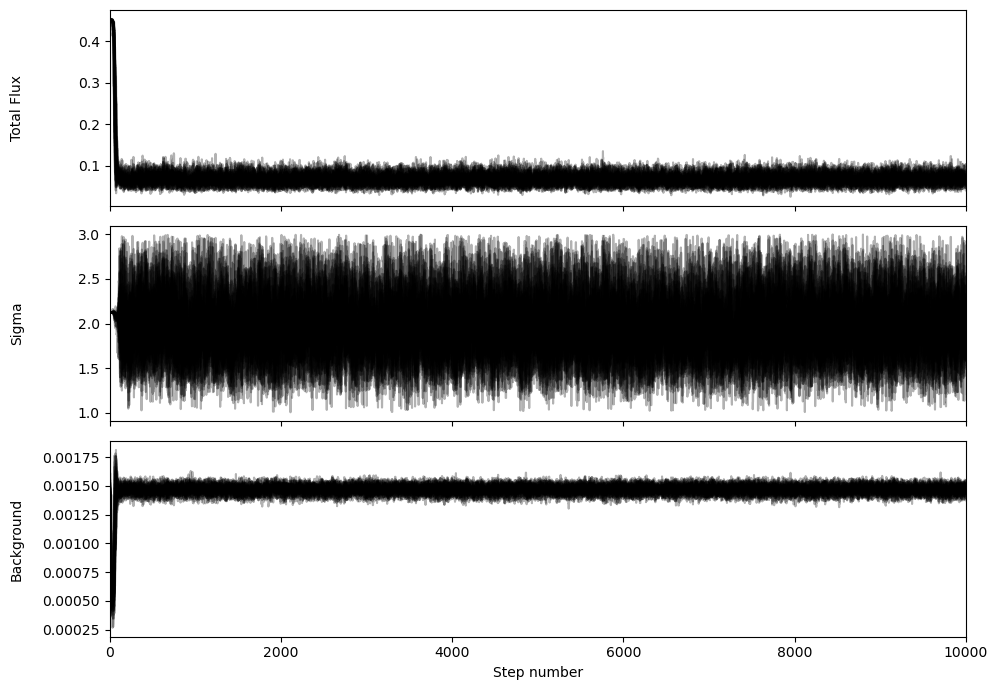

Best-fit parameters:
Total Flux: 0.068 +0.013 -0.011
Sigma: 1.949 +0.326 -0.295
Background: 0.001 +0.000 -0.000


In [6]:
# Set up the MCMC sampler
ndim = 3  # Number of parameters to fit (total_flux, sigma, background)
nwalkers = 32  # Number of MCMC walkers
nsteps = 10000  # Number of MCMC steps

# Initialize the walkers
initial_guess = [np.mean(flux), 5/2.355, (flux[-1]-flux[-2])/(np.pi * (aperture_radii[-1]**2-aperture_radii[-2]**2))]
pos = initial_guess + 1e-4 * np.random.randn(nwalkers, ndim)

# Run the MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(aperture_radii, flux, flux_err))
sampler.run_mcmc(pos, nsteps, progress=True)

# Plot the MCMC results
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Total Flux", "Sigma", "Background"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("Step number")
plt.tight_layout()
plt.show()

# Print the best-fit parameters
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print("Best-fit parameters:")
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(f"{labels[i]}: {mcmc[1]:.3f} +{q[1]:.3f} -{q[0]:.3f}")

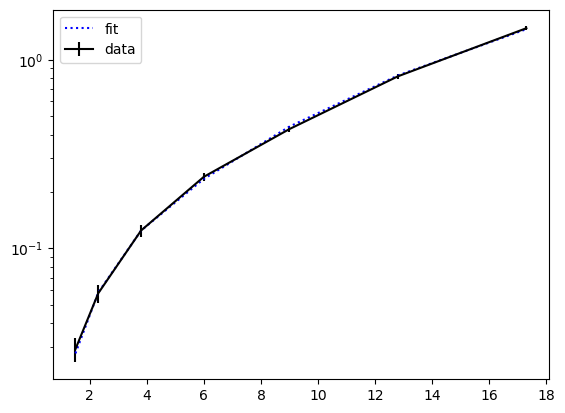

In [7]:
plt.errorbar(aperture_radii,flux,yerr=flux_err,fmt='k-',label='data')
plt.plot(aperture_radii,
         gaussian_flux_model([np.percentile(flat_samples[:, 0], [16, 50, 84])[1],
                              np.percentile(flat_samples[:, 1], [16, 50, 84])[1],
                              np.percentile(flat_samples[:, 2], [16, 50, 84])[1],], aperture_radii),'b:',label='fit')
plt.legend()
plt.semilogy();